## Settin up imports and divece agnostic code

In [60]:
import random
import pandas as pd
import numpy as np
import torch
from torchvision import models
from torch import nn
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets
import zipfile
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

In [61]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Downloading data

In [62]:
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content/data

Saving kaggle.json to kaggle (1).json
dogs-vs-cats-redux-kernels-edition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [63]:
# Path to ZIP file
zip_path = 'data/dogs-vs-cats-redux-kernels-edition.zip'

# Extract content of zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('data')


# Define the path to the zip file
train_zip_path = os.path.join('data', 'train.zip')

# Define paths for 'cat' and 'dog' directories
cat_dir = os.path.join('data', 'train', 'cat')
dog_dir = os.path.join('data', 'train', 'dog')

# Create directories if they don't exist
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Extract images to respective folders based on their names
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
  for file_info in zip_ref.infolist():
    file_info.filename = file_info.filename.split('/')[1]
    if "cat" in file_info.filename:
        zip_ref.extract(file_info, cat_dir)
    elif "dog" in file_info.filename:
        zip_ref.extract(file_info, dog_dir)


# Extract test.zip
train_zip_path = os.path.join('data', 'test.zip')
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('data')

In [64]:
TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'

## Transforming `.jpg` images to tensors

### Prepare Image Processing

In [65]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.RandomHorizontalFlip(p=0.5), # Flip the images randomly on the horizontal
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet's mean and std
])

### Loading data image using ImageFolder

In [66]:
train_data = datasets.ImageFolder(root=TRAIN_DIR,
                                  transform=data_transform,
                                  target_transform=None)

train_data

Dataset ImageFolder
    Number of datapoints: 25000
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
           )

In [67]:
class_names = train_data.classes
class_names

['cat', 'dog']

In [68]:
class_dict = train_data.class_to_idx
class_dict

{'cat': 0, 'dog': 1}

In [69]:
len(train_data)

25000

In [70]:
train_data.samples[:10]

[('data/train/cat/cat.0.jpg', 0),
 ('data/train/cat/cat.1.jpg', 0),
 ('data/train/cat/cat.10.jpg', 0),
 ('data/train/cat/cat.100.jpg', 0),
 ('data/train/cat/cat.1000.jpg', 0),
 ('data/train/cat/cat.10000.jpg', 0),
 ('data/train/cat/cat.10001.jpg', 0),
 ('data/train/cat/cat.10002.jpg', 0),
 ('data/train/cat/cat.10003.jpg', 0),
 ('data/train/cat/cat.10004.jpg', 0)]

In [71]:
rnd_idx = random.randrange(len(train_data))
img, label = train_data[rnd_idx][0], train_data[rnd_idx][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.9882, 0.9882, 0.9882,  ..., 0.4431, 0.4588, 0.4078],
         [0.9882, 0.9882, 0.9882,  ..., 0.4431, 0.4549, 0.4275],
         [0.9882, 0.9882, 0.9882,  ..., 0.4392, 0.4353, 0.4392],
         ...,
         [0.5020, 0.5098, 0.5059,  ..., 0.4980, 0.4824, 0.5020],
         [0.4941, 0.5020, 0.4980,  ..., 0.5373, 0.5294, 0.5608],
         [0.4902, 0.4941, 0.4941,  ..., 0.5529, 0.5569, 0.5569]],

        [[0.9922, 0.9922, 0.9922,  ..., 0.4706, 0.4745, 0.4078],
         [0.9922, 0.9922, 0.9922,  ..., 0.4706, 0.4745, 0.4275],
         [0.9922, 0.9922, 0.9922,  ..., 0.4627, 0.4549, 0.4431],
         ...,
         [0.5412, 0.5490, 0.5490,  ..., 0.5059, 0.4863, 0.5020],
         [0.5333, 0.5412, 0.5412,  ..., 0.5451, 0.5373, 0.5647],
         [0.5294, 0.5373, 0.5373,  ..., 0.5608, 0.5647, 0.5686]],

        [[0.9725, 0.9725, 0.9725,  ..., 0.3569, 0.3922, 0.3647],
         [0.9725, 0.9725, 0.9725,  ..., 0.3608, 0.3882, 0.3765],
         [0.9725, 0.9725, 0.9725,  ..., 0.3

Original: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute: torch.Size([224, 224, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'cat')

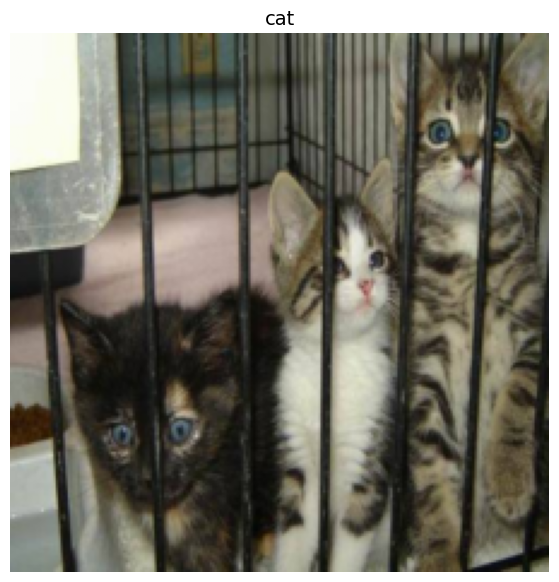

In [72]:
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

### Turn loaded images into DataLoader

In [73]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

In [74]:
len(train_dataloader)

782

In [75]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Image shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Image shape: torch.Size([32])


## Building model

### Create transform with data augmentation

In [76]:
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
  ])

### Create `Dataset` and `DataLoader` with data augmentation

In [77]:
train_data_augmented = datasets.ImageFolder(root=TRAIN_DIR,
                                            transform=train_transform_trivial)

In [78]:
NUM_WORKERS = os.cpu_count()
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

### Creating functions for train/test loop

In [79]:
model = models.resnet50(pretrained=True)

# Remove the last fully connected layer (fc) to customize the model
num_features = model.fc.in_features
model.fc = nn.Sequential()

# Add custom layers for binary classification
custom_classifier = nn.Sequential(
  nn.Linear(num_features, 512),
  nn.ReLU(),

  nn.Linear(512, 1),
  nn.Sigmoid()
)

model.fc = custom_classifier

model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [80]:
param_to_optimize=[]
for name, param in model.named_parameters():
  print(name)
  if('fc' in name):
    param.requires_grad = True
    param_to_optimize.append(param)
  else:
    param.requires_grad = False

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [81]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [82]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):

  train_loss, train_acc = 0, 0
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X).squeeze()
    # print(f"y_pred shape: \n{y_pred.shape}\n\ny_pred: \n{y_pred}\n\ny_pred.squeeze(): \n{y_pred.squeeze()}\n")
    # print(f"\ny.shape: {y.shape}")
    loss = loss_fn(y_pred, y.type(torch.float32))
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y, y_pred=torch.round(y_pred))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs=5,
          device=device
        ):

  results = {
      "loss": [],
      "accuracy": [],
  }

  for epoch in range(epochs):
    loss, acc = train_step(model=model, dataloader=dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)

    print(f"Epoch: {epoch} | Loss: {loss:.8f} | Accuracy: {acc:.8f}")

    results["loss"].append(loss)
    results["accuracy"].append(acc)

  return results

### Try a forward pass on a single image (to test the model)

In [83]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_augmented))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [84]:
# Try a forward pass
model.eval()
with torch.inference_mode():
  res = model(image_batch.to(device))
  res_arg = torch.round(res)

res, res_arg

(tensor([[0.4924],
         [0.5100],
         [0.4924],
         [0.4828],
         [0.4894],
         [0.4611],
         [0.5161],
         [0.4636],
         [0.4966],
         [0.5022],
         [0.4855],
         [0.4834],
         [0.5175],
         [0.4966],
         [0.4764],
         [0.5083],
         [0.4867],
         [0.4975],
         [0.5047],
         [0.4871],
         [0.4783],
         [0.4968],
         [0.4885],
         [0.4978],
         [0.4736],
         [0.4840],
         [0.4861],
         [0.5156],
         [0.4798],
         [0.5071],
         [0.5047],
         [0.5144]], device='cuda:0'),
 tensor([[0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]

### Setting up loss function and optimizer

In [85]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(params=param_to_optimize, lr=0.001, momentum=0.9)

### Train model

In [86]:
# Set the number of epochs
NUM_EPOCHS = 10

model_results = train(model=model,
                      dataloader=train_dataloader_augmented,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      device=device)

Epoch: 0 | Loss: 0.20408157 | Accuracy: 92.86684783
Epoch: 1 | Loss: 0.12499093 | Accuracy: 94.68909847
Epoch: 2 | Loss: 0.11814954 | Accuracy: 95.05674552
Epoch: 3 | Loss: 0.11599807 | Accuracy: 95.07273018
Epoch: 4 | Loss: 0.10820102 | Accuracy: 95.52429668
Epoch: 5 | Loss: 0.11458755 | Accuracy: 95.16863811
Epoch: 6 | Loss: 0.11362436 | Accuracy: 95.15664962
Epoch: 7 | Loss: 0.10622935 | Accuracy: 95.53628517
Epoch: 8 | Loss: 0.10471325 | Accuracy: 95.66416240
Epoch: 9 | Loss: 0.10740006 | Accuracy: 95.32848465


In [87]:
for i in range(len(model_results["loss"])):
  model_results["loss"][i] = model_results["loss"][i].item()

<class 'list'>


Text(0.5, 0, 'Epochs')

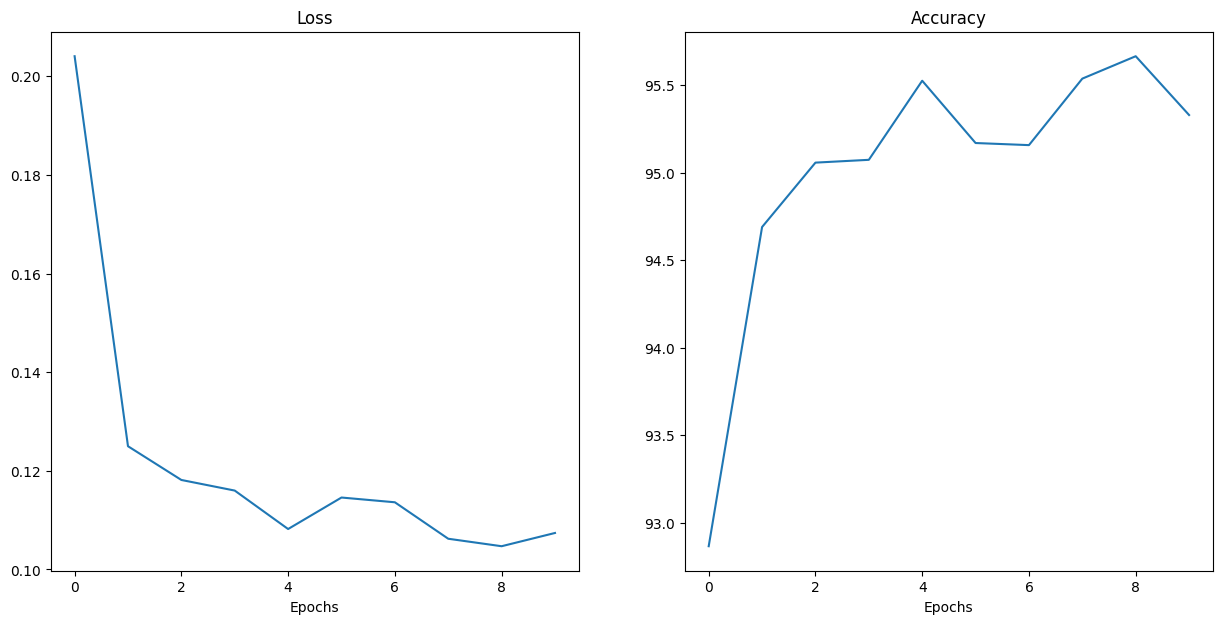

In [88]:
loss = model_results["loss"]
acc = model_results["accuracy"]
epochs = range(len(loss))

print(type(loss))

# Setup plot
plt.figure(figsize=(15, 7))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="Loss")
plt.title("Loss")
plt.xlabel("Epochs")

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label="Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")

In [89]:
def save_model(model, filepath, save_state_dict=True):
    if save_state_dict:
        torch.save(model.state_dict(), filepath)
    else:
        torch.save(model, filepath)

In [90]:
save_model(model, 'cats_vs_dogs_model_0.pth', save_state_dict=True)

## Making predictions

In [91]:
model.load_state_dict(torch.load('cats_vs_dogs_model_0.pth', map_location=device))

<All keys matched successfully>

In [92]:
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
  ])

In [93]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_labels = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.img_labels[idx]

In [94]:
img_dir = "data/test"

# Create dataset
test_data = CustomImageDataset(img_dir=img_dir, transform=test_transform)

# Create DataLoader
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [95]:
len(test_loader)

391

In [96]:
# Getting predictions along with labels

labels = []
preds = []

model.eval()
with torch.inference_mode():
  for batch, (X, y) in enumerate(test_loader):
    X = X.to(device)
    y_pred = model(X).squeeze()

    print(f"batch {batch} out of {len(test_loader)}")

    labels += y
    preds += y_pred

labels, preds

batch 0 out of 391
batch 1 out of 391
batch 2 out of 391
batch 3 out of 391
batch 4 out of 391
batch 5 out of 391
batch 6 out of 391
batch 7 out of 391
batch 8 out of 391
batch 9 out of 391
batch 10 out of 391
batch 11 out of 391
batch 12 out of 391
batch 13 out of 391
batch 14 out of 391
batch 15 out of 391
batch 16 out of 391
batch 17 out of 391
batch 18 out of 391
batch 19 out of 391
batch 20 out of 391
batch 21 out of 391
batch 22 out of 391
batch 23 out of 391
batch 24 out of 391
batch 25 out of 391
batch 26 out of 391
batch 27 out of 391
batch 28 out of 391
batch 29 out of 391
batch 30 out of 391
batch 31 out of 391
batch 32 out of 391
batch 33 out of 391
batch 34 out of 391
batch 35 out of 391
batch 36 out of 391
batch 37 out of 391
batch 38 out of 391
batch 39 out of 391
batch 40 out of 391
batch 41 out of 391
batch 42 out of 391
batch 43 out of 391
batch 44 out of 391
batch 45 out of 391
batch 46 out of 391
batch 47 out of 391
batch 48 out of 391
batch 49 out of 391
batch 50 o

(['1.jpg',
  '10.jpg',
  '100.jpg',
  '1000.jpg',
  '10000.jpg',
  '10001.jpg',
  '10002.jpg',
  '10003.jpg',
  '10004.jpg',
  '10005.jpg',
  '10006.jpg',
  '10007.jpg',
  '10008.jpg',
  '10009.jpg',
  '1001.jpg',
  '10010.jpg',
  '10011.jpg',
  '10012.jpg',
  '10013.jpg',
  '10014.jpg',
  '10015.jpg',
  '10016.jpg',
  '10017.jpg',
  '10018.jpg',
  '10019.jpg',
  '1002.jpg',
  '10020.jpg',
  '10021.jpg',
  '10022.jpg',
  '10023.jpg',
  '10024.jpg',
  '10025.jpg',
  '10026.jpg',
  '10027.jpg',
  '10028.jpg',
  '10029.jpg',
  '1003.jpg',
  '10030.jpg',
  '10031.jpg',
  '10032.jpg',
  '10033.jpg',
  '10034.jpg',
  '10035.jpg',
  '10036.jpg',
  '10037.jpg',
  '10038.jpg',
  '10039.jpg',
  '1004.jpg',
  '10040.jpg',
  '10041.jpg',
  '10042.jpg',
  '10043.jpg',
  '10044.jpg',
  '10045.jpg',
  '10046.jpg',
  '10047.jpg',
  '10048.jpg',
  '10049.jpg',
  '1005.jpg',
  '10050.jpg',
  '10051.jpg',
  '10052.jpg',
  '10053.jpg',
  '10054.jpg',
  '10055.jpg',
  '10056.jpg',
  '10057.jpg',
  '10058.j

In [97]:
# Converting labels and preds to suitable format

id_label_tuples = []

for i in range(len(preds)):
  id = int(labels[i].split('.')[0])
  pred = preds[i].item()
  id_label_tuples.append((id, pred))

id_label_tuples

[(1, 0.9972139000892639),
 (10, 0.012754618190228939),
 (100, 0.00032107604783959687),
 (1000, 0.9985696077346802),
 (10000, 0.9987275004386902),
 (10001, 0.00025761142023839056),
 (10002, 0.0007302166195586324),
 (10003, 0.997515082359314),
 (10004, 0.85120689868927),
 (10005, 0.0013871024129912257),
 (10006, 0.0001398519380018115),
 (10007, 3.1105359084904194e-05),
 (10008, 4.6103908971417695e-05),
 (10009, 0.00015237262414302677),
 (1001, 1.7258231309824623e-05),
 (10010, 0.9989587068557739),
 (10011, 0.9994718432426453),
 (10012, 1.3965302969154436e-05),
 (10013, 0.07372841984033585),
 (10014, 0.0001746745256241411),
 (10015, 0.9993202686309814),
 (10016, 0.0015226774848997593),
 (10017, 1.4019345144333784e-05),
 (10018, 4.771681051352061e-05),
 (10019, 4.0789069316815585e-05),
 (1002, 0.9999798536300659),
 (10020, 0.00032809903495945036),
 (10021, 9.514234989183024e-05),
 (10022, 0.9982670545578003),
 (10023, 0.9998812675476074),
 (10024, 0.9782224893569946),
 (10025, 0.9982587695

In [98]:
# Sorting array of tuples by id
sorted_array_of_tuples = sorted(id_label_tuples, key=lambda x: x[0])
sorted_array_of_tuples

[(1, 0.9972139000892639),
 (2, 0.9998842477798462),
 (3, 0.9997742772102356),
 (4, 0.9992965459823608),
 (5, 0.00028872810071334243),
 (6, 0.0002969417837448418),
 (7, 1.5248634554154705e-05),
 (8, 0.00015443432494066656),
 (9, 2.3676569981034845e-05),
 (10, 0.012754618190228939),
 (11, 0.0001736742415232584),
 (12, 0.9983477592468262),
 (13, 0.00018829156761057675),
 (14, 0.004472339991480112),
 (15, 0.00012030007201246917),
 (16, 0.0004908356349915266),
 (17, 0.9686746597290039),
 (18, 0.9998975992202759),
 (19, 2.6487485229154117e-05),
 (20, 0.0008675100980326533),
 (21, 0.9996942281723022),
 (22, 0.0016362742753699422),
 (23, 0.9998262524604797),
 (24, 0.9944180250167847),
 (25, 9.166778909275308e-05),
 (26, 0.9928394556045532),
 (27, 0.9981898665428162),
 (28, 2.184437107644044e-05),
 (29, 0.2704131603240967),
 (30, 0.9937626719474792),
 (31, 0.9998040795326233),
 (32, 0.006124002393335104),
 (33, 0.9924099445343018),
 (34, 6.684439722448587e-05),
 (35, 0.0002840994275175035),
 (3

In [99]:
# Create the DataFrame
df = pd.DataFrame(sorted_array_of_tuples, columns=['id', 'label'])
df

,id,label
0,1,0.997214
1,2,0.999884
2,3,0.999774
3,4,0.999297
4,5,0.000289
...,...,...
12495,12496,0.000006
12496,12497,0.000094
12497,12498,0.993647
12498,12499,0.999783


In [100]:
# Save predictions to csv
df.to_csv('dogs_vs_cats_submission.csv', index=False)